# GOAL: notifications + divergence notifications
------------------------------------------------------------------------------
- Bollinger Band............. yes
- RSI........................ yes
- RSI Divergence............. no
- MACD....................... yes
- MVWAP....................... no
- RVI........................ yes
- MFI........................ no
- Min & Max lines............ yes
- Moving Averages............ no
- Candlestick Patterns....... yes
- Risk Analysis.............. no
- Earnings & Financials...... no
- News....................... yes
- Put/Call Ratio............. no
- Trending................... no
- Consolodating.............. no
- Buy Score:   Some #/#

In [1]:
#importing variables
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import matplotlib.dates as mpl_dates
import seaborn as sns
import matplotlib.pyplot as plt
import math
from openpyxl import load_workbook
# Find local peaks
from scipy.signal import argrelextrema
import yfinance as yf
import talib, time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pythoncom

In [2]:
# Function to get Bollinger Bands
def getBBands(df, period=10, stdNbr=2):
        try:
            close = df['Close']
        except Exception as ex:
            return None

        try:
            upper, middle, lower = talib.BBANDS(
                                close.values, 
                                timeperiod=period,
                                # number of non-biased standard deviations from the mean
                                nbdevup=stdNbr,
                                nbdevdn=stdNbr,
                                # Moving average type: simple moving average here
                                matype=0)
        except Exception as ex:
            return None

        data = dict(upper=upper, middle=middle, lower=lower, close=close)
        df = pd.DataFrame(data, index=df.index, columns=['upper', 'middle', 'lower','close']).dropna()

        return df 


In [3]:
# Smoothing with Wilder puts emphasis on recent values
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [4]:
# Function that indicates buy/sell signal
def buy_sell_MACD(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal['MACD'][i] > signal['signal'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal["Close"][i])
                flag = 1 
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['signal'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
                
            else:
                Sell.append(np.nan)
            
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
                
    return(Buy, Sell)

In [5]:
# Function that indicates buy/sell signal
def buy_sell_RVI(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal['RVI'][i] > signal['RVI_Signal'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal["Close"][i])
                flag = 1 
            else:
                Buy.append(np.nan)
        elif signal['RVI'][i] < signal['RVI_Signal'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
                
            else:
                Sell.append(np.nan)
            
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
                
    return(Buy, Sell)

In [6]:
# Import data for the year of ticker(s)
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []
tickers_final = ['SPY']

for i in tickers_final:
    try:
        test_data = yf.download(tickers=i, period = '1y', interval = '1d')
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
    except Exception as e:
        no_data.append(i)
        print(e)
df_copy=all_data.copy()

[*********************100%***********************]  1 of 1 completed


In [7]:
all_data.head(3)


,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-12-27,472.059998,477.309998,472.010010,477.260010,469.640869,56808600,SPY
2021-12-28,477.720001,478.809998,476.059998,476.869995,469.257050,47274600,SPY
2021-12-29,476.980011,478.559998,475.920013,477.480011,469.857391,54503000,SPY


In [8]:
# Makes RSI column and initializes RSI parameter variables
all_data['RSI'] = talib.RSI(all_data['Close'], timeperiod=14)
lower_barrier = 40
upper_barrier = 70
width = 5
all_data
# Sets up different dataset for finding RSI divergence
Data = all_data.copy()
Data.drop(['Volume','Adj Close','symbol'], axis=1, inplace=True)
Data.head(20)

,Open,High,Low,Close,RSI
Date,,,,,
2021-12-27,472.059998,477.309998,472.010010,477.260010,NaN
2021-12-28,477.720001,478.809998,476.059998,476.869995,NaN
2021-12-29,476.980011,478.559998,475.920013,477.480011,NaN
2021-12-30,477.929993,479.000000,475.670013,476.160004,NaN
2021-12-31,475.640015,476.859985,474.670013,474.959991,NaN
2022-01-03,476.299988,477.850006,473.850006,477.709991,NaN
2022-01-04,479.220001,479.980011,475.579987,477.549988,NaN
2022-01-05,477.160004,477.980011,468.279999,468.380005,NaN
2022-01-06,467.890015,470.820007,465.429993,467.940002,NaN


In [9]:
Data['Bullish Divergence'] = ""
Data['Bearish Divergence'] = ""
bearish_below = ['']
bullish_above = ['']
# Bullish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] < lower_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] > lower_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] < lower_barrier and Data.iloc[r, 4] > Data.iloc[i, 4] and Data.iloc[r, 3] < Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] > lower_barrier:
                                    bullish_above.append(Data.iloc[s+1,1])
                                    print('Bullish above',Data.iloc[s+1,1])
                                    Data.iloc[s + 1, 5] = 1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError as e:
        print(e)
        pass
    
        
#Bearish Divergence
for i in range(len(Data)):
    try:
        if Data.iloc[i, 4] > upper_barrier:
            for a in range(i + 1, i + width): 
                if Data.iloc[a, 4] < upper_barrier:
                    for r in range(a + 1, a + width):
                        if Data.iloc[r, 4] > upper_barrier and Data.iloc[r, 4] < Data.iloc[i, 4] and Data.iloc[r, 3] > Data.iloc[i, 3]:
                            for s in range(r + 1, r + width):
                                if Data.iloc[s, 4] < upper_barrier:
                                    bearish_below.append(Data.iloc[s+1,2])
                                    print('Bearish below',Data.iloc[s+1,2])
                                    Data.iloc[s + 1, 6] = -1
                                    break
                                else:
                                    continue
                        else:
                            continue
                else:
                    continue
        else:
            continue
    except IndexError:
        pass

Bullish above 426.42999267578125
Bullish above 435.67999267578125
Bullish above 435.67999267578125
Bullish above 425.0
Bullish above 425.0
Bullish above 425.0
Bullish above 425.0
Bullish above 425.0
Bullish above 425.0
Bullish above 425.0
Bullish above 395.1499938964844
Bullish above 395.1499938964844
Bullish above 395.1499938964844
Bullish above 395.1499938964844
Bullish above 395.1499938964844
Bullish above 395.1499938964844
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 370.260009765625
Bullish above 375.45001220703125
Bullish above 375.45001220703125
Bullish above 375.45001220703125
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


In [10]:
bull_above = []
for i in bullish_above:
    if i not in bull_above and len(str(i)) > 0:
        bull_above.append(i)
        
bear_below = []
for i in bearish_below:
    if i not in bear_below and len(str(i)) > 0:
        bear_below.append(i)        
bull_above


[426.42999267578125,
 435.67999267578125,
 425.0,
 395.1499938964844,
 370.260009765625,
 375.45001220703125]

In [11]:
# # Creates Return column
# all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 
# all_data.head(5)

In [12]:
# Fixes index problem
all_data = all_data[~all_data.index.duplicated()]

# Columns dropped for testing
# all_data.drop(index=all_data.index[:-220], axis=0, inplace=True)
# all_data.drop(index=all_data.index[-20:], axis=0, inplace=True)
all_data.tail(4)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI
Date,,,,,,,,
2022-12-20,379.230011,382.230011,377.850006,380.540009,380.540009,74427200,SPY,39.410787
2022-12-21,383.250000,387.410004,382.690002,386.230011,386.230011,78167400,SPY,45.202618
2022-12-22,383.049988,386.209991,374.769989,380.720001,380.720001,100120900,SPY,41.104928
2022-12-23,379.649994,383.059998,378.029999,382.910004,382.910004,59761100,SPY,43.304807


In [13]:
# Tries with high sensitivity level
n = 7
all_data['min'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']


In [14]:
# Tries with medium sensitivity level
n = 12
all_data['min1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max1'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']

In [15]:
# Extra sensitivity level (optional)
n = 25
all_data['min4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.less_equal,
                    order=n)[0]]['Close']
all_data['max4'] = all_data.iloc[argrelextrema(all_data['Close'].values, np.greater_equal,
                    order=n)[0]]['Close']
all_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,min,max,min1,max1,min4,max4
Date,,,,,,,,,,,,,,
2022-12-19,383.470001,383.820007,378.279999,380.019989,380.019989,79878100,SPY,38.862400,380.019989,NaN,380.019989,NaN,380.019989,NaN
2022-12-20,379.230011,382.230011,377.850006,380.540009,380.540009,74427200,SPY,39.410787,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-21,383.250000,387.410004,382.690002,386.230011,386.230011,78167400,SPY,45.202618,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-22,383.049988,386.209991,374.769989,380.720001,380.720001,100120900,SPY,41.104928,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-23,379.649994,383.059998,378.029999,382.910004,382.910004,59761100,SPY,43.304807,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Draws lines for the mins and maxes - first performs shift operations
all_data['prev_min'] = all_data['min'].shift(1)
all_data['min'] = all_data.apply(lambda x : 0  if ((x['min'] == x['prev_min'])) else x['min'], axis=1)
all_data['prev_max'] = all_data['max'].shift(1)
all_data['max'] = all_data.apply(lambda x : 0  if ((x['max'] == x['prev_max'])) else x['max'], axis=1)

all_data['prev_min1'] = all_data['min1'].shift(1)
all_data['min1'] = all_data.apply(lambda x : 0  if ((x['min1'] == x['prev_min1'])) else x['min1'], axis=1)
all_data['prev_max1'] = all_data['max1'].shift(1)
all_data['max1'] = all_data.apply(lambda x : 0  if ((x['max1'] == x['prev_max1'])) else x['max1'], axis=1)

all_data['prev_min2'] = all_data['min4'].shift(1)
all_data['min4'] = all_data.apply(lambda x : 0  if ((x['min4'] == x['prev_min2'])) else x['min4'], axis=1)
all_data['prev_max2'] = all_data['max4'].shift(1)
all_data['max4'] = all_data.apply(lambda x : 0  if ((x['max4'] == x['prev_max2'])) else x['max4'], axis=1)

# n = smaller number
all_data['min2'] = all_data['min'].replace({0:np.nan})
all_data.min2 = all_data['min2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max2'] = all_data['max'].replace({0:np.nan})
all_data.max2 = all_data['max2'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
# n = larger number
all_data['min3'] = all_data['min1'].replace({0:np.nan})
all_data.min3 = all_data['min3'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max3'] = all_data['max1'].replace({0:np.nan})
all_data.max3 = all_data['max3'].interpolate(method='spline', limit_direction='forward',order = 1, axis=0)
# n = (optional other)
all_data['min5'] = all_data['min4'].replace({0:np.nan})
all_data.min5 = all_data['min5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)
all_data['max5'] = all_data['max4'].replace({0:np.nan})
all_data.max5 = all_data['max5'].interpolate(method='spline', limit_direction='both',order = 1, axis=0)

In [17]:
# all_data['RSI_DIV'] = all_data['RSI'] / all_data['min3'] 
# all_data['RSI_DIV1'] = all_data['RSI'] / all_data['max3'] 
# all_data.tail(5)

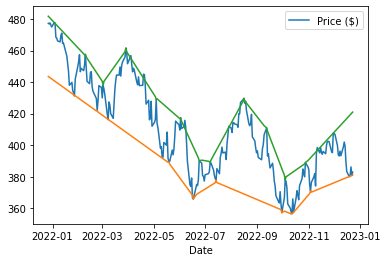

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min2)
plt.plot(all_data.max2)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

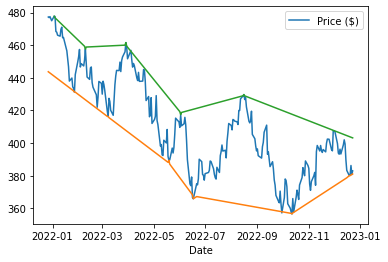

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min3)
plt.plot(all_data.max3)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

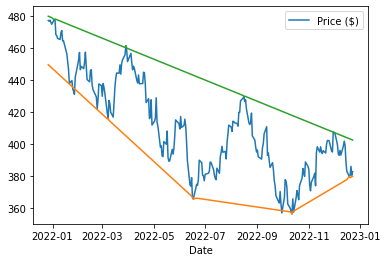

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
# plt.plot(all_data.Close)
plt.plot(all_data.min5)
plt.plot(all_data.max5)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

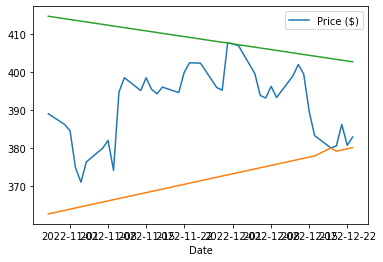

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.tail(40).Close)
# plt.plot(all_data.Close)
plt.plot(all_data.tail(40).min5)
plt.plot(all_data.tail(40).max5)
plt.xlabel('Date')
plt.legend(['Price ($)'])
plt.show()

In [22]:
# Bollinger Band function used
all_data = all_data.merge(getBBands(all_data,period=20,stdNbr=2), on = 'Date')

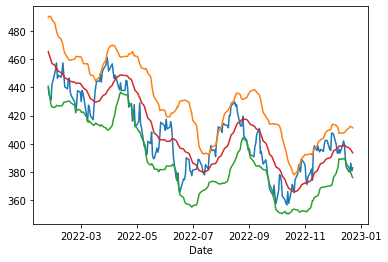

In [23]:
# Big picture
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_data.Close)
plt.plot(all_data.upper)
plt.plot(all_data.lower)
plt.plot(all_data.middle)
plt.xlabel('Date')

# plt.legend(['Price ($)','Max5','Min5','Max3','Min3','Max2','Min2'], loc = 'upper left')
plt.show()

In [24]:
# We want notifications for all these plus divergence notifications:
# Buy/Sell when crosses middle band
# Bollinger Band............. yes
# RSI........................ yes
# RSI Divergence............. no
# MACD....................... yes
# VWAP....................... no
# RVI........................ yes
# MFI........................ no
# Min & Max lines............ yes
# Moving Averages............ no
# Candlestick Patterns....... yes
# Risk Analysis.............. no
# Earnings & Financials...... no
# News....................... yes
# Put/Call Ratio............. no
# Trending................... no
# Consolodating.............. no
# Buy Score: 

In [25]:
# MACD Calculations: check if it is higher than the signal (bullish)
all_data['ShortEMA'] = all_data.Close.transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['LongEMA'] = all_data.Close.transform(lambda x: x.ewm(span=35, adjust=False).mean())
all_data['MACD'] = all_data.ShortEMA - all_data.LongEMA
all_data['signal'] = all_data.MACD.transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['macd_bullish'] = all_data.apply(lambda x : 1 if (x['MACD'] - x['signal'] > 0) else 0, axis = 1)

In [26]:
# Plotting MACD buy/sell signals
a = buy_sell_MACD(all_data)
df = all_data[['Close']]
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]

C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


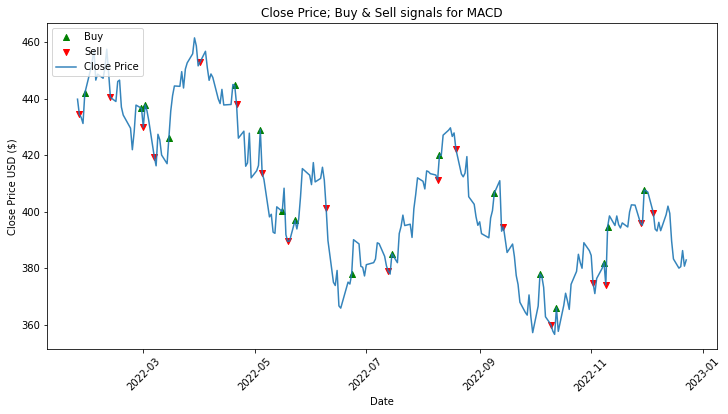

In [27]:
#Show buy/sell signals for MACD
plt.figure(figsize=(12,6))
plt.scatter(all_data.index, df['Buy_Signal_Price'],
            color='green', 
            label='Buy', 
            marker = '^', 
            alpha=1)
plt.scatter(df.index, df['Sell_Signal_Price'],
            color='red', 
            label='Sell', 
            marker = 'v', 
            alpha=1)
plt.plot(df['Close'], label='Close Price', alpha = 0.9)
plt.title('Close Price; Buy & Sell signals for MACD')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [28]:
# Shifts in MACD and RVI are used to determine signal direction
# All the necessary calculations for the RVI, including the RVI Signal (lot of shifting to get past data)
df = all_data.copy()
df['open_shift'] = df.Open.shift(1)
df['open_shift2'] = df.Open.shift(2)
df['open_shift3'] = df.Open.shift(3)
df['low_shift'] = df.Low.shift(1)
df['low_shift2'] = df.Low.shift(2)
df['low_shift3'] = df.Low.shift(3)

df['numerator'] = ((1 * (df.Close - df.Open)) + (2 * (df.Close - df.open_shift)) + (2 * (df.Close - df.open_shift2)) + 
                   (1 * (df.Close - df.open_shift3))) / 6
df['denominator'] = (1 * (df.High - df.Low) + (2 * (df.High - df.low_shift)) + (2 * (df.High - df.low_shift2)) + 
                   (1 * (df.High - df.low_shift3))) / 6

df['SMA_numerator'] = df['numerator'].transform(lambda x: x.rolling(window = 10).mean())
df['SMA_denominator'] = df['denominator'].transform(lambda x: x.rolling(window = 10).mean())   
df['RVI'] = df['SMA_numerator'] / df['SMA_denominator']          
df['rvishift'] = df.RVI.shift(1)
df['rvishift2'] = df.RVI.shift(2)
df['rvishift3'] = df.RVI.shift(3)

df['RVI_Signal'] = ((1* df.RVI) + (2 * df.rvishift) + (2 * df.rvishift2) + (1*df.rvishift3)) / 6
df['rvi_bullish'] = df.apply(lambda x : 1 if (x['RVI'] - x['RVI_Signal'] > 0) else 0, axis = 1)
all_data = df.copy()

In [29]:
# Plotting RVI buy/sell signals
b = buy_sell_RVI(all_data)
df2 = all_data[['Close']]
df2['Buy_Signal_Price'] = b[0]
df2['Sell_Signal_Price'] = b[1]

C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\amoog\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


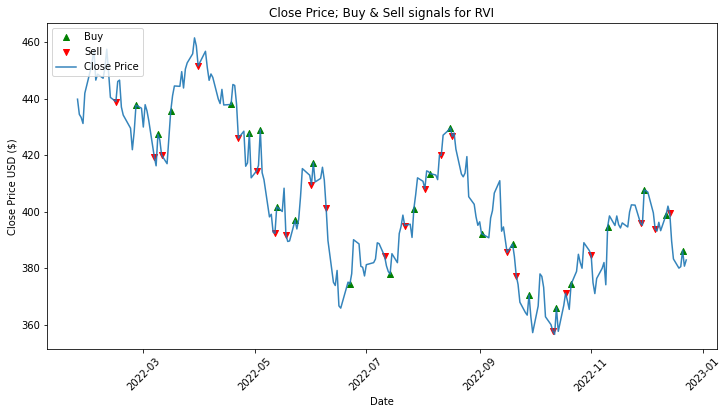

In [30]:
#Show buy/sell signals for RVI
plt.figure(figsize=(12,6))
plt.scatter(all_data.index, df2['Buy_Signal_Price'],
            color='green', 
            label='Buy', 
            marker = '^', 
            alpha=1)
plt.scatter(df2.index, df2['Sell_Signal_Price'],
            color='red', 
            label='Sell', 
            marker = 'v', 
            alpha=1)
plt.plot(df2['Close'], label='Close Price', alpha = 0.9)
plt.title('Close Price; Buy & Sell signals for RVI')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [31]:
# ATR and ADX are used to determine signal strength
# ATR ratio and ADX is used to figure out a true range, for volatility
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                    np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                    abs(all_data['prev_close'] - all_data['Low'])))

for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)
all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']

# Took this code from the internet for ATR AND ADX for a different project, along with the Wilder smoothing stuff
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                        np.where((all_data['High'] > all_data['prev_high']) & 
        (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                all_data['High'] - all_data['prev_high'], 
                                                                0),np.nan)
all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                        np.where((all_data['prev_low'] > all_data['Low']) & 
        (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100
all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

# Determine if the stock has momentum and volatility (strength of the signal)
all_data['adx_signal'] = all_data.apply(lambda x : 1 if (x['ADX_15'] >= 25) else 0, axis = 1)
all_data['atr_signal'] = all_data.apply(lambda x : 1 if (x['ATR_Ratio'] >= 1) else 0, axis = 1)


In [32]:
all_data

,Open,High,Low,Close,Adj Close,Volume,symbol,RSI,min,max,...,+DM,-DM,+DM_15,-DM_15,+DI_15,-DI_15,DX_15,ADX_15,adx_signal,atr_signal
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-24,432.029999,440.380005,420.760010,439.839996,432.818237,251783900,SPY,17.875630,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2022-01-25,433.059998,439.720001,427.149994,434.470001,427.533997,167997300,SPY,15.855705,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2022-01-26,440.720001,444.040009,428.859985,433.380005,426.461395,186391100,SPY,15.473498,NaN,NaN,...,4.320007,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2022-01-27,438.260010,441.589996,429.450012,431.239990,424.355499,149878300,SPY,14.723106,431.239990,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2022-01-28,432.679993,442.000000,427.820007,441.950012,434.894592,164457400,SPY,32.393515,NaN,NaN,...,0.000000,1.630005,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,383.470001,383.820007,378.279999,380.019989,380.019989,79878100,SPY,38.862400,380.019989,NaN,...,0.000000,2.760010,1.801286,2.270274,24.875021,31.351560,12.0,15.666050,0,1
2022-12-20,379.230011,382.230011,377.850006,380.540009,380.540009,74427200,SPY,39.410787,NaN,NaN,...,0.000000,0.429993,1.681200,2.147589,23.844821,30.459712,12.0,15.421646,0,0
2022-12-21,383.250000,387.410004,382.690002,386.230011,386.230011,78167400,SPY,45.202618,NaN,NaN,...,5.179993,0.000000,1.914453,2.004416,27.199542,28.477693,2.0,14.526870,0,0


In [33]:
# Looped version (for when there are multiple tickers)
import datetime
with open ('datasets/companies2.csv') as f:
    finviz_url = 'https://finviz.com/quote.ashx?t='
#     companies = f.read().splitlines()\
#     companies = ['HEPA']
    companies = tickers_final
    scores = []
    symbols = []
    news_tables = {}

    for company in companies:
        try:
            score = 0
            daynum = 60

            tod = datetime.datetime.now()
            d = datetime.timedelta(days = daynum)
            a = tod - d
    
#             symbol = (company.split(',') [0])
#             df = yf.download(symbol,threads= False,start = a, end = tod)
            symbol = df['symbol'][0]
            df = df_copy.tail(60).copy()
    
            
            morning_star = talib.CDLMORNINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
            engulfing = talib.CDL3STARSINSOUTH(df['Open'], df['High'], df['Low'], df['Close'])
            outside = talib.CDL3OUTSIDE(df['Open'], df['High'], df['Low'], df['Close'])
            white = talib.CDL3WHITESOLDIERS(df['Open'], df['High'], df['Low'], df['Close'])
            belt = talib.CDLBELTHOLD(df['Open'], df['High'], df['Low'], df['Close'])
            baby = talib.CDLCONCEALBABYSWALL(df['Open'], df['High'], df['Low'], df['Close'])
            evening = talib.CDLEVENINGSTAR(df['Open'], df['High'], df['Low'], df['Close'])
            invhammer = talib.CDLINVERTEDHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
            hammer = talib.CDLHAMMER(df['Open'], df['High'], df['Low'], df['Close'])
            longline = talib.CDLLONGLINE(df['Open'], df['High'], df['Low'], df['Close'])
            morningdoji = talib.CDLMORNINGDOJISTAR(df['Open'], df['High'], df['Low'], df['Close'])
            eveningdoji = talib.CDLEVENINGDOJISTAR(df['Open'], df['High'], df['Low'], df['Close'])
            piercing = talib.CDLPIERCING(df['Open'], df['High'], df['Low'], df['Close'])
            risefall = talib.CDLRISEFALL3METHODS(df['Open'], df['High'], df['Low'], df['Close'])
            separating = talib.CDLSEPARATINGLINES(df['Open'], df['High'], df['Low'], df['Close'])
            south = talib.CDL3STARSINSOUTH(df['Open'], df['High'], df['Low'], df['Close'])
            crows = talib.CDL3BLACKCROWS(df['Open'], df['High'], df['Low'], df['Close'])
            takuri = talib.CDLTAKURI(df['Open'], df['High'], df['Low'], df['Close'])
            sidegap = talib.CDLXSIDEGAP3METHODS(df['Open'], df['High'], df['Low'], df['Close'])
            
            df['morning_star'] = morning_star
            df['engulfing'] = engulfing
            df['outside'] = outside
            df['white'] = white
            df['belt'] = belt
            df['baby'] = baby
            df['evening'] = evening
            df['invhammer'] = invhammer
            df['hammer'] = hammer
            df['longline'] = longline
            df['morningdoji'] = morningdoji
            df['eveningdoji'] = eveningdoji
            df['piercing'] = piercing
            df['risefall'] = risefall
            df['separating'] = separating
            df['south'] = south
            df['crows'] = crows
            df['takuri'] = takuri
            df['sidegap'] = sidegap
            display(df)
            
            i = 1
            temp_df = df.copy()
            
            while i < 5:
                score += (temp_df['morning_star'].tail(1).values.sum() * 1.75) * 0.78 / i
                score += (temp_df['engulfing'].tail(1).values.sum() * 1.75) * 0.63 / i
                score += (temp_df['outside'].tail(1).values.sum() * 1.75) * 0.75 / i
                score += (temp_df['white'].tail(1).values.sum() * 1.75) * 0.82 / i
                score += (temp_df['belt'].tail(1).values.sum() * 1.75) * 0.71 / i
                score += (temp_df['baby'].tail(1).values.sum() * 1.75) * 0.70 / i
                score += (temp_df['evening'].tail(1).values.sum() * 1.75) * 0.72 / i
                score += (temp_df['invhammer'].tail(1).values.sum() * 1.75) * 0.65 / i
                score += (temp_df['hammer'].tail(1).values.sum() * 1.75) * 0.6 / i
                score += (temp_df['longline'].tail(1).values.sum() * 1.75) * 0.66 / i
                score += (temp_df['morningdoji'].tail(1).values.sum() * 1.75) * 0.76 / i
                score += (temp_df['eveningdoji'].tail(1).values.sum() * 1.75) * 0.71 / i
                score += (temp_df['piercing'].tail(1).values.sum() * 1.75) * 0.67 / i
                score += (temp_df['risefall'].tail(1).values.sum() * 1.75) * 0.71 / i
                score += (temp_df['separating'].tail(1).values.sum() * 1.75) * 0.72 / i
                score += (temp_df['south'].tail(1).values.sum() * 1.75) * 0.86 / i
                score += (temp_df['crows'].tail(1).values.sum() * 1.75) * 0.78 / i
                score += (temp_df['takuri'].tail(1).values.sum() * 1.5) * 0.66 / i
                score += (temp_df['sidegap'].tail(1).values.sum() * 1.75) * 0.62 / i
                temp_df.drop(temp_df.tail(1).index,inplace=True) # drop last row
                i+=1

            if (score != 0):
                current_score = score
                scores.append(current_score)
                symbols.append(symbol)

            # when adding personal stocks
            else:
                current_score = 70
                scores.append(current_score)
                symbols.append(symbol)
        except Exception as e:
            print (e)
            pass


    stonks = dict(zip(symbols, scores)) 
    mid = pd.DataFrame.from_dict(stonks, orient = 'index', columns = ['Score'])
    mid = mid.astype({"Score": np.float16})
    mid = mid.sort_values(by = 'Score', ascending = False).head(24)
    df_new = mid.rename_axis('Ticker').head(24)
    print(df_new)
    tickers = df_new.index.tolist()

    charts = []
    n = 3
    for ticker in tickers:
        try:
            url = finviz_url + ticker
            req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
            resp = urlopen(req)    
            html = BeautifulSoup(resp, features="lxml")
            news_table = html.find(id='news-table')
            news_tables[ticker] = news_table
            charts.append(str(url))
        except:
            pass


    try:
        for ticker in tickers:

            df1 = news_tables[ticker]
            df_tr = df1.findAll('tr')
            
            display (df1)
            display (df_tr)
            print ('\n')
            print ('Recent News Headlines for {}: '.format(ticker))

            for i, table_row in enumerate(df_tr):
                a_text = table_row.a.text
                td_text = table_row.td.text
                td_text = td_text.strip()
                print(a_text,'(',td_text,')')
                if i == n-1:
                    break

    except KeyError:
        pass

    # Iterate through the news
    parsed_news = []
    for file_name, news_table in news_tables.items():
        for x in news_table.findAll('tr'):
            text = x.a.get_text() 
            date_scrape = x.td.text.split()

            if len(date_scrape) == 1:
                time = date_scrape[0]

            else:
                date = date_scrape[0]
                time = date_scrape[1]

            ticker = file_name.split('_')[0]

            parsed_news.append([ticker, date, time, text])

    # Sentiment Analysis
    analyzer = SentimentIntensityAnalyzer()

    columns = ['Ticker', 'Date', 'Time', 'Headline']
    news = pd.DataFrame(parsed_news, columns=columns)
    scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

    df_scores = pd.DataFrame(scores)
    news = news.join(df_scores, rsuffix='_right')


    # View Data 
    news['Date'] = pd.to_datetime(news.Date).dt.date

    unique_ticker = news['Ticker'].unique().tolist()
    news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

    values = []
    for ticker in tickers: 
        try:
            dataframe = news_dict[ticker]
            dataframe = dataframe.set_index('Ticker')
            dataframe = dataframe.drop(columns = ['Headline'])
            print ('\n')
            print (dataframe.head())

            mean = round(dataframe['compound'].mean(), 2)
            values.append(mean)
        except:
            pass

    df1 = pd.DataFrame(list(zip(tickers, values, charts)), columns =['Ticker', 'Mean Sentiment', 'Chart']) 
    df1 = df1.sort_values(by=['Mean Sentiment'], ascending=False)
    print(df1)
    # df1['Mean Sentiment'] = (df1['Mean Sentiment'] * 100) 
    df1 = df1.astype({"Mean Sentiment": np.float16})
    df1['Mean Sentiment'] = df1.apply(lambda x : (1 + x['Mean Sentiment']) if (x['Mean Sentiment'] >= 0) else 1 - x['Mean Sentiment'], axis = 1)
    print ('\n')
    print (df_new)

    new = pd.merge(df_new, df1, on = 'Ticker', how = 'outer')
    new['Final Sentiment'] = new.apply(lambda x : (x['Mean Sentiment'] * x['Score']) if (x['Score'] >= 0 and x['Mean Sentiment'] >= 0) else x['Score'], axis = 1)
    new = new.sort_values(by=['Final Sentiment'], ascending=False)

    print (new)
    final_scores = new['Final Sentiment'].tolist()
    final_tickers = new.Ticker.tolist()
    stocks = dict(zip(final_tickers, final_scores))

new.to_excel( r'C:\Users\amoog\Desktop\Stock_Notifier\Stock_Notifier\spreadsheets\{fdate}.xlsx'.format(fdate = 'Sentiment ' + tod.strftime("%d-%m-%Y")), sheet_name = 'today', index=False)

,Open,High,Low,Close,Adj Close,Volume,symbol,morning_star,engulfing,outside,...,longline,morningdoji,eveningdoji,piercing,risefall,separating,south,crows,takuri,sidegap
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-30,361.799988,365.910004,357.040009,357.179993,355.547302,153711200,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-03,361.079987,368.549988,359.209991,366.609985,364.934204,89756500,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-04,372.399994,378.000000,366.570007,377.970001,376.242279,103602800,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-05,373.390015,379.459991,370.950012,377.089996,375.366302,88065700,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-06,375.619995,378.720001,372.679993,373.200012,371.494110,82333500,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-07,368.970001,373.290009,360.940002,362.790009,361.131683,107789500,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-10,363.959991,364.209991,357.670013,360.019989,358.374329,76042800,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-11,358.239990,363.029999,355.709991,357.739990,356.104767,92482800,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-12,358.170013,359.820007,356.299988,356.559998,354.930145,76991800,SPY,0,0,0,...,0,0,0,0,0,0,0,0,0,0


          Score
Ticker         
SPY     79.9375
Empty DataFrame
Columns: [Ticker, Mean Sentiment, Chart]
Index: []


          Score
Ticker         
SPY     79.9375
  Ticker    Score Mean Sentiment Chart  Final Sentiment
0    SPY  79.9375            NaN   NaN          79.9375
